In [1]:
# Install required libraries
!pip install yfinance timesfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 14.6 MB/s eta

In [1]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


2024-09-04 09:02:27.480428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia


In [2]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [16]:
import yfinance as yf
import pandas as pd

# دانلود داده‌های سهام
ticker = 'AAPL'
data = yf.download(ticker, start="2000-01-01", end="2024-01-01")

# بازنمونه‌گیری (resample) به صورت روزانه و پر کردن مقادیر گمشده
data_resampled = data.dropna()

# تبدیل به DataFrame و تنظیم فرمت نهایی
df = data_resampled[['Close']].reset_index()
df.columns = ['date', 'close']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df


[*********************100%***********************]  1 of 1 completed


,close
date,
2000-01-03,0.999442
2000-01-04,0.915179
2000-01-05,0.928571
2000-01-06,0.848214
2000-01-07,0.888393
...,...
2023-12-22,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [6]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [7]:


# Define metrics
def mse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)

In [8]:
import timesfm


context_len=512
input_patch_len=32
horizon_len=1
batch_size = 1


model = timesfm.TimesFm(
    context_len=context_len,
    horizon_len=horizon_len,
    input_patch_len=input_patch_len,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

2024-09-04 09:02:50.635589: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.41 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.37 seconds.
Jitting decoding.
Jitted decoding in 22.95 seconds.


In [17]:
import timesfm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
import gc

# تنظیمات اولیه
context_lengths = range(32, 513, 32)  # لیستی از context_len های مختلف برای آزمایش (باید مضرب 32 باشد)
results_by_context_len = []

# تنظیم تاریخ شروع برای پیش‌بینی
start_date = pd.to_datetime("2023-04-05")

batch_size = 1  # ثابت نگه‌داشتن batch size
horizon_len = 1  # ثابت نگه‌داشتن horizon length
input_patch_len = 32  # ثابت نگه‌داشتن input_patch_len

for context_len in context_lengths:
    print(f"Processing context_len: {context_len}")

    # تنظیم داده‌ها
    start_idx = df.index.get_loc(start_date) - context_len

    while start_idx + context_len < len(df):
        # تعیین بازه زمانی بر اساس context_len
        end_idx = start_idx + context_len
        inputs = df['close'].iloc[start_idx:end_idx].tolist()

        # پیش‌بینی برای روز جاری
        raw_forecast, _ = model.forecast(
            inputs=[inputs], freq=[0] * len(inputs)
        )
        predict_date = df.index[end_idx]
        y_actual = df['close'].iloc[end_idx]

        # اضافه کردن جزئیات بیشتر به نتیجه
        result = {
            'input_index': start_idx + context_len,
            'train_start_date': df.index[start_idx],
            'train_end_date': df.index[end_idx-1],
            'predict_date': predict_date,
            'raw_forecast': raw_forecast[0][0],
            'y_actual': y_actual,
            'context_len': context_len,
            'input_patch_len': input_patch_len
        }
        results_by_context_len.append(result)

        # به‌روزرسانی شاخص شروع برای پیش‌بینی بعدی
        start_idx += 1

# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results_by_context_len)

# ذخیره DataFrame به صورت pickle
results_df.to_pickle('results_df_input_context.pkl')

# نمایش پیغام موفقیت‌آمیز بودن عملیات
print("DataFrame successfully saved as 'results_df_basic.pkl'.")


Processing context_len: 32
Processing context_len: 64
Processing context_len: 96
Processing context_len: 128
Processing context_len: 160
Processing context_len: 192
Processing context_len: 224
Processing context_len: 256
Processing context_len: 288
Processing context_len: 320
Processing context_len: 352
Processing context_len: 384
Processing context_len: 416
Processing context_len: 448
Processing context_len: 480
Processing context_len: 512
DataFrame successfully saved as 'results_df_basic.pkl'.


In [26]:
 results_df = pd.DataFrame(results_by_context_len)
 results_df=results_df[:-1]
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,context_len,input_patch_len
0,5851,2023-02-17,2023-04-04,2023-04-05,165.536377,163.759995,32,32
1,5852,2023-02-21,2023-04-05,2023-04-06,163.684219,164.660004,32,32
2,5853,2023-02-22,2023-04-06,2023-04-10,164.382507,162.029999,32,32
3,5854,2023-02-23,2023-04-10,2023-04-11,162.146530,160.800003,32,32
4,5855,2023-02-24,2023-04-11,2023-04-12,160.873322,160.100006,32,32
...,...,...,...,...,...,...,...,...
2970,6031,2021-12-08,2023-12-20,2023-12-21,195.222382,194.679993,512,32
2971,6032,2021-12-09,2023-12-21,2023-12-22,194.300415,193.600006,512,32
2972,6033,2021-12-10,2023-12-22,2023-12-26,193.330566,193.050003,512,32
2973,6034,2021-12-13,2023-12-26,2023-12-27,193.033737,193.149994,512,32


In [28]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1
    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return  capital - initial_capital

def calculate_final_results(context_lengths, results_by_context_len):
    final_results = []

    for context_len in context_lengths:

        context_results_df = pd.DataFrame([res for res in results_by_context_len if res['context_len'] == context_len])
        if len(context_results_df) == 0:
            print(f"No data available for context_len = {context_len}. Skipping this context_len.")
            continue

        mse_value = calculate_mse(context_results_df)
        accuracy_value = calculate_accuracy(context_results_df)
        profit = calculate_profit(context_results_df)
        direction_accuracy = calculate_direction_accuracy(context_results_df)
        actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
        direction_profit = calculate_direction_profit(context_results_df)

        final_results.append({
            'context_len': context_len,
            'mse': mse_value,
            'accuracy': accuracy_value,
            'direction_accuracy': direction_accuracy,
            'actual_direction_accuracy': actual_direction_accuracy,
            'direction_profit': direction_profit,
            'profit': profit
        })

    return pd.DataFrame(final_results)




In [29]:
results_by_context_len = results_df.to_dict(orient='records')

final_result=calculate_final_results(context_lengths,results_by_context_len)
final_result

,context_len,mse,accuracy,direction_accuracy,actual_direction_accuracy,direction_profit,profit
0,32,5.190726,0.508108,0.497297,0.508108,9.079142,7.038784
1,64,5.460012,0.454054,0.502703,0.454054,10.803209,6.391389
2,96,4.989477,0.497297,0.545946,0.497297,17.562990,10.476344
3,128,5.388982,0.502703,0.529730,0.508108,11.947982,20.867085
4,160,5.877848,0.470270,0.508108,0.470270,10.487291,10.915638
5,192,6.408804,0.518919,0.518919,0.524324,12.051794,13.710594
6,224,6.243502,0.508108,0.497297,0.513514,4.952559,5.141020
7,256,6.150466,0.551351,0.475676,0.551351,0.263532,21.009066
8,288,6.023025,0.518919,0.475676,0.518919,-0.383953,17.193097
9,320,6.753792,0.529730,0.508108,0.529730,8.364927,14.767834


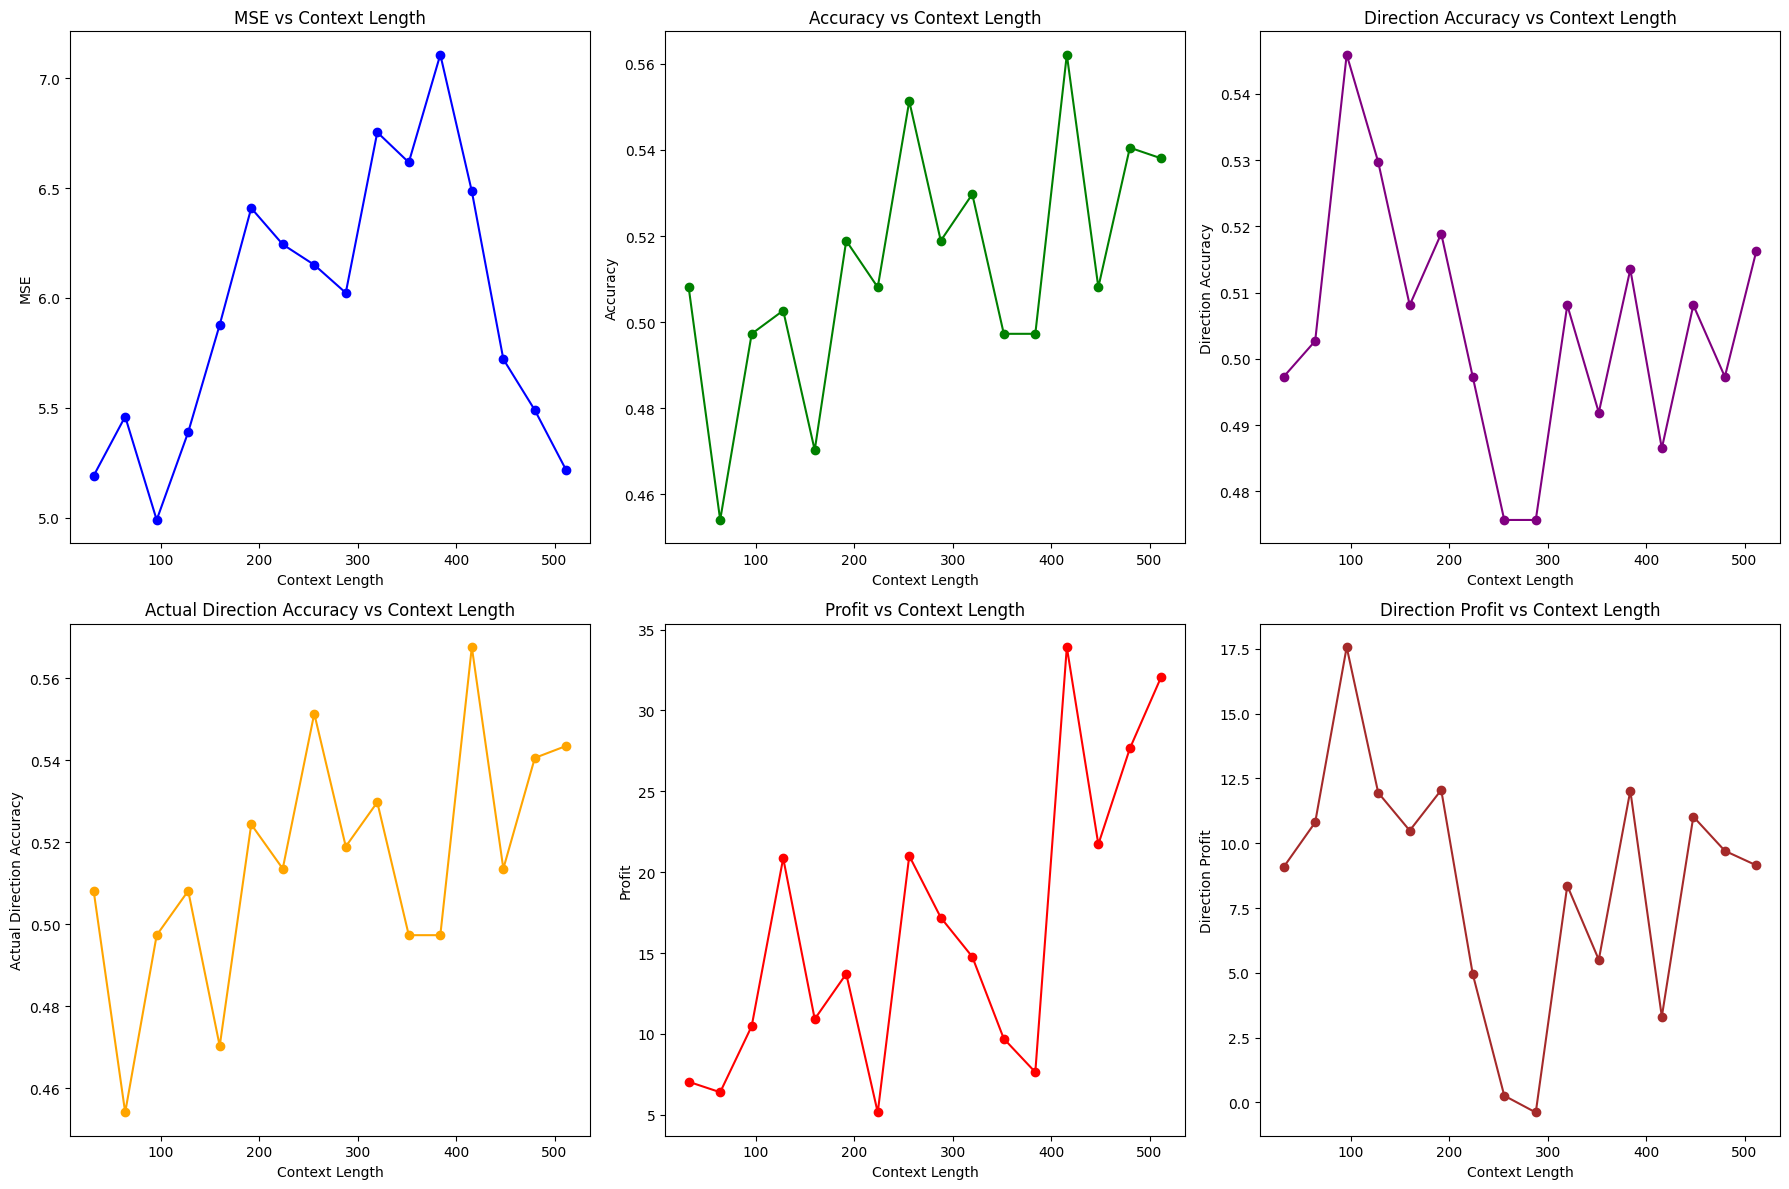

In [30]:
import matplotlib.pyplot as plt

# رسم نمودار تغییرات MSE، Accuracy، Direction Accuracy، Actual Direction Accuracy، Profit و Direction Profit بر حسب context_len
plt.figure(figsize=(18, 12))

# نمودار MSE
plt.subplot(2, 3, 1)
plt.plot(final_result['context_len'], final_result['mse'], marker='o', color='blue')
plt.title('MSE vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('MSE')

# نمودار Accuracy
plt.subplot(2, 3, 2)
plt.plot(final_result['context_len'], final_result['accuracy'], marker='o', color='green')
plt.title('Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Accuracy')

# نمودار Direction Accuracy
plt.subplot(2, 3, 3)
plt.plot(final_result['context_len'], final_result['direction_accuracy'], marker='o', color='purple')
plt.title('Direction Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Direction Accuracy')

# نمودار Actual Direction Accuracy
plt.subplot(2, 3, 4)
plt.plot(final_result['context_len'], final_result['actual_direction_accuracy'], marker='o', color='orange')
plt.title('Actual Direction Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Actual Direction Accuracy')

# نمودار Profit
plt.subplot(2, 3, 5)
plt.plot(final_result['context_len'], final_result['profit'], marker='o', color='red')
plt.title('Profit vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Profit')

# نمودار Direction Profit
plt.subplot(2, 3, 6)
plt.plot(final_result['context_len'], final_result['direction_profit'], marker='o', color='brown')
plt.title('Direction Profit vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Direction Profit')

plt.tight_layout()
plt.show()


In [31]:
# پیدا کردن context_len که بیشترین مقدار هر معیار را دارد

# MSE
min_mse = final_result.loc[final_result['mse'].idxmin()]
print(f"Minimum MSE: {min_mse['mse']} at Context Length: {min_mse['context_len']}")

# Accuracy
max_accuracy = final_result.loc[final_result['accuracy'].idxmax()]
print(f"Maximum Accuracy: {max_accuracy['accuracy']} at Context Length: {max_accuracy['context_len']}")

# Direction Accuracy
max_direction_accuracy = final_result.loc[final_result['direction_accuracy'].idxmax()]
print(f"Maximum Direction Accuracy: {max_direction_accuracy['direction_accuracy']} at Context Length: {max_direction_accuracy['context_len']}")

# Actual Direction Accuracy
max_actual_direction_accuracy = final_result.loc[final_result['actual_direction_accuracy'].idxmax()]
print(f"Maximum Actual Direction Accuracy: {max_actual_direction_accuracy['actual_direction_accuracy']} at Context Length: {max_actual_direction_accuracy['context_len']}")

# Profit
max_profit = final_result.loc[final_result['profit'].idxmax()]
print(f"Maximum Profit: {max_profit['profit']} at Context Length: {max_profit['context_len']}")

# Direction Profit
max_direction_profit = final_result.loc[final_result['direction_profit'].idxmax()]
print(f"Maximum Direction Profit: {max_direction_profit['direction_profit']} at Context Length: {max_direction_profit['context_len']}")


Minimum MSE: 4.989476930636722 at Context Length: 96.0
Maximum Accuracy: 0.5621621621621622 at Context Length: 416.0
Maximum Direction Accuracy: 0.5459459459459459 at Context Length: 96.0
Maximum Actual Direction Accuracy: 0.5675675675675675 at Context Length: 416.0
Maximum Profit: 33.91828377720242 at Context Length: 416.0
Maximum Direction Profit: 17.56299034872319 at Context Length: 96.0


In [32]:
initial_investment = 100
initial_price = results_df['y_actual'].iloc[0]
final_price = results_df['y_actual'].iloc[-1]


# Calculate the number of shares bought initially
shares_bought = initial_investment / initial_price

# Calculate the final value of the investment
final_investment_value = shares_bought * final_price

# Calculate the total profit
buy_and_hold_profit = final_investment_value - initial_investment
buy_and_hold_profit

18.209580071141218